# Figure2(Stackedbar) for bertopic

In [1]:
import sys, os
p = os.path.abspath('..')
sys.path.insert(1, p)

pp = os.path.abspath('../../visualization')
sys.path.insert(1, pp)

In [2]:
from gc import collect

from utils.statistics import *
from utils.settings import set_matplotlib
from distribution_collector import (collect_topic_distributions,
                                get_top_and_bottom_topics,
                                extract_specific_topics)
from constants import CONSTANTS
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib as mpl

import psycopg2
import pandas as pd
import numpy as np
from utils.statistics import *
import config.config as conf
import datetime
import re
# 포뮬러 구성
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd


In [3]:
from matplotlib import font_manager
import matplotlib as mpl
from matplotlib import font_manager as fm

# 설치된 폰트 이름과 경로 확인
for font in font_manager.fontManager.ttflist:
    if 'Helvetica' in font.name: # 'Nanum' 대신 원하는 글꼴의 일부를 입력하여 검색할 수 있습니다.
        print(font.name, font.fname)

# 직접 경로로 Helvetica 폰트 불러오기
font_path = "/System/Library/Fonts/Helvetica.ttc"
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
print(f"Registered font name: {font_name}")

mpl.rcParams['font.family'] = font_name


Helvetica /System/Library/Fonts/Helvetica.ttc
Helvetica Neue /System/Library/Fonts/HelveticaNeue.ttc
Registered font name: Helvetica


In [4]:
data_dir = f'../../visualization/{CONSTANTS.bert_monthly_data_dir[3:]}'
output_dir = './fig/'
date_range = 'Weekly'
model = 'BERT'


# DID

In [5]:
data_dir = f'../../visualization/{CONSTANTS.bert_monthly_data_dir_3[3:]}'
lst = os.listdir(data_dir)
df = pd.DataFrame()
# 디렉토리 내의 파일을 for 문으로 반복
for i in lst:
	js = load_json(f'{data_dir}/{i}')
	tmp = pd.DataFrame(js)
	df = pd.concat([df, tmp], axis = 0)

In [6]:
print(data_dir)

../../visualization/result/bert_based/run_id_3/data


In [7]:
sorted(lst)

['0.json',
 '1.json',
 '10.json',
 '11.json',
 '12.json',
 '13.json',
 '14.json',
 '15.json',
 '16.json',
 '17.json',
 '18.json',
 '19.json',
 '2.json',
 '20.json',
 '21.json',
 '22.json',
 '23.json',
 '24.json',
 '25.json',
 '26.json',
 '27.json',
 '28.json',
 '29.json',
 '3.json',
 '30.json',
 '31.json',
 '32.json',
 '33.json',
 '34.json',
 '35.json',
 '36.json',
 '37.json',
 '38.json',
 '39.json',
 '4.json',
 '40.json',
 '41.json',
 '42.json',
 '43.json',
 '44.json',
 '45.json',
 '46.json',
 '47.json',
 '48.json',
 '49.json',
 '5.json',
 '50.json',
 '51.json',
 '52.json',
 '53.json',
 '54.json',
 '55.json',
 '56.json',
 '57.json',
 '58.json',
 '59.json',
 '6.json',
 '60.json',
 '61.json',
 '62.json',
 '63.json',
 '7.json',
 '8.json',
 '9.json']

In [8]:
print(df['creationdate'].min())
print(df['creationdate'].max())

2020-11-30 00:04:44.453000
2023-11-30 23:52:28.800000


In [9]:
df = df[['id', 'creationdate', 'Topic']].copy()

In [10]:
# ----> 1 top10list = list(df[(df['cdate']>='2021-11-30')&(df['cdate']<'2022-11-30')].groupby('Topic').count()['id'].reset_index().sort_values(by = 'id', ascending=False)['Topic'][:10])
#       2 bot10list = list(df[(df['cdate']>='2021-11-30')&(df['cdate']<'2022-11-30')].groupby('Topic').count()['id'].reset_index().sort_values(by = 'id', ascending=False)['Topic'][-10:])

In [11]:
df['creationdate'] = pd.to_datetime(df['creationdate'], format="mixed")
df['cdate'] = pd.to_datetime(df['creationdate'], format="%Y-%m-%d").dt.date
df['cdate'] = pd.to_datetime(df['cdate'], format="%Y-%m-%d")


In [12]:
top10list = list(df[(df['cdate']>='2021-11-30')&(df['cdate']<'2022-11-30')].groupby('Topic').count()['id'].reset_index().sort_values(by = 'id', ascending=False)['Topic'][:10])
bot10list = list(df[(df['cdate']>='2021-11-30')&(df['cdate']<'2022-11-30')].groupby('Topic').count()['id'].reset_index().sort_values(by = 'id', ascending=False)['Topic'][-10:])

In [13]:
df_did = df.groupby(['cdate', 'Topic']).count()['id'].reset_index(name = 'cnt')

In [14]:
df_did.loc[df_did['cdate'] =='2020-11-30', 'cnt'].sum()

794

In [15]:
std_date = datetime.datetime(2022, 11, 30)
pre_std_date = datetime.datetime(2021, 12, 1)

df_did['post_rel_week'] = np.floor((df_did['cdate']-std_date).dt.days/7)
df_did['pre_rel_week'] = np.floor((df_did['cdate']-pre_std_date).dt.days/7)

In [16]:
# 일자별로 토픽별 비율을 계산
df_did_tot = df_did.groupby(['cdate']).sum(['cnt'])['cnt'].reset_index(name = 'tot_cnt')
df_pct = pd.merge(df_did, df_did_tot, on = 'cdate')
df_pct['pct_byday'] = df_pct['cnt']/df_pct['tot_cnt']

# 상위 하위에 포함되는 태그만 추출
df_pct_top = df_pct[df_pct['Topic'].isin(top10list)].reset_index(drop=True)
df_pct_bot = df_pct[df_pct['Topic'].isin(bot10list)].reset_index(drop=True)

#DID수행을 위해서 top/bottom에 대한  pre/post추출
df_top_af = df_pct_top[(df_pct_top['post_rel_week'] >=-20) & (df_pct_top['post_rel_week'] <20)  ]
df_top_bf = df_pct_top[(df_pct_top['pre_rel_week'] >=-20) & (df_pct_top['pre_rel_week'] <20)  ]

df_bot_af = df_pct_bot[(df_pct_bot['post_rel_week'] >=-20) & (df_pct_bot['post_rel_week'] <20)  ]
df_bot_bf = df_pct_bot[(df_pct_bot['pre_rel_week'] >=-20) & (df_pct_bot['pre_rel_week'] <20)  ]

# DiD  수행시 필요한 계수 (post treat) 추출
df_top_af.loc[:, 'treated'] = 1
df_top_bf.loc[:, 'treated'] = 0

df_bot_af.loc[:, 'treated'] = 1
df_bot_bf.loc[:, 'treated'] = 0

df_top_af.loc[:, 'post'] = np.where(df_top_af['post_rel_week']<0, 0, 1)
df_top_bf.loc[:, 'post'] = np.where(df_top_bf['pre_rel_week']<0, 0, 1)

df_bot_af.loc[:, 'post'] = np.where(df_bot_af['post_rel_week']<0, 0, 1)
df_bot_bf.loc[:, 'post'] = np.where(df_bot_bf['pre_rel_week']<0, 0, 1)



df_top_bf = df_top_bf.rename(columns= {'pre_rel_week':'rel_week'})
df_bot_bf = df_bot_bf.rename(columns= {'pre_rel_week':'rel_week'})

df_top_af = df_top_af.rename(columns= {'post_rel_week':'rel_week'})
df_bot_af = df_bot_af.rename(columns= {'post_rel_week':'rel_week'})



df_bot_for_did = pd.concat([df_bot_bf[['rel_week', 'cdate', 'pct_byday', 'treated', 'post']], df_bot_af[['rel_week', 'cdate', 'pct_byday', 'treated', 'post']]])
df_top_for_did = pd.concat([df_top_bf[['rel_week', 'cdate', 'pct_byday', 'treated', 'post']], df_top_af[['rel_week', 'cdate', 'pct_byday', 'treated', 'post']]])





/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_52991/3598514678.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_af.loc[:, 'treated'] = 1
/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_52991/3598514678.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_bf.loc[:, 'treated'] = 0
/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_52991/3598514678.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [17]:
# df_bot_bf.loc[df_bot_bf['cdate'] =='2021-08-18', 'cnt'].sum()

In [18]:
# df_bot_bf

In [19]:
# df_bot_for_did
# df_top_for_did

In [20]:
# df_bot_for_did = df_bot_for_did.groupby(['rel_week', 'cdate', 'treated', 'post']).sum()['pct_byday'].reset_index()
# df_top_for_did = df_top_for_did.groupby(['rel_week', 'cdate', 'treated', 'post']).sum()['pct_byday'].reset_index()

In [21]:
df_top_for_did[(df_top_for_did['rel_week'] ==-20)&(df_top_for_did['cdate'] =='2021-07-14')]

,rel_week,cdate,pct_byday,treated,post
2260,-20.0,2021-07-14,0.046683,0,0
2261,-20.0,2021-07-14,0.063882,0,0
2262,-20.0,2021-07-14,0.051597,0,0
2263,-20.0,2021-07-14,0.034398,0,0
2264,-20.0,2021-07-14,0.025799,0,0
2265,-20.0,2021-07-14,0.027027,0,0
2266,-20.0,2021-07-14,0.039312,0,0
2267,-20.0,2021-07-14,0.031941,0,0
2268,-20.0,2021-07-14,0.030713,0,0
2269,-20.0,2021-07-14,0.029484,0,0


In [22]:
def calc_did(data, measure):
    data['rel_week'] = data['rel_week'].astype('category')
    # 회귀식: 주차별 상호작용 포함
    model = smf.ols(f"{measure} ~ C(rel_week) * treated", data=data)
    did_result = model.fit(cov_type='HAC', cov_kwds={'maxlags': 7}) 

    return did_result

In [23]:
def pp_did_result(did_result) :
    # 결과 정리
    periods = np.arange(-19,19, 1)
    coefs = did_result.params
    std_errors = did_result.bse 
    conf = did_result.conf_int()
    print(coefs)
    coefs_filtered      = coefs.loc[[f'C(rel_week)[T.{i}.0]:treated' for i in periods]].values
    std_errors_filtered = std_errors.loc[[f'C(rel_week)[T.{i}.0]:treated' for i in periods]].values

    # 신뢰구간 계산
    ll_95 = coefs_filtered - 1.965 * std_errors_filtered
    ul_95 = coefs_filtered + 1.965 * std_errors_filtered

    # 데이터프레임 생성 (계수와 신뢰구간)
    df_coefs = pd.DataFrame({
        'period'    : periods,
        'Estimate'  : coefs_filtered,
        'll_95'     : ll_95,
        'ul_95'     : ul_95
    })
    return df_coefs




In [24]:
top_did_result = calc_did(df_top_for_did, 'pct_byday')
bot_did_result = calc_did(df_bot_for_did , 'pct_byday')

top_event_effects = pp_did_result(top_did_result)
bot_event_effects = pp_did_result(bot_did_result)


Intercept                      0.036783
C(rel_week)[T.-19.0]           0.001549
C(rel_week)[T.-18.0]           0.000166
C(rel_week)[T.-17.0]          -0.001395
C(rel_week)[T.-16.0]           0.001166
                                 ...   
C(rel_week)[T.15.0]:treated   -0.003339
C(rel_week)[T.16.0]:treated   -0.002968
C(rel_week)[T.17.0]:treated   -0.001901
C(rel_week)[T.18.0]:treated   -0.002093
C(rel_week)[T.19.0]:treated   -0.002793
Length: 80, dtype: float64
Intercept                      0.007778
C(rel_week)[T.-19.0]           0.000264
C(rel_week)[T.-18.0]          -0.000406
C(rel_week)[T.-17.0]           0.000928
C(rel_week)[T.-16.0]           0.000051
                                 ...   
C(rel_week)[T.15.0]:treated    0.003258
C(rel_week)[T.16.0]:treated    0.003687
C(rel_week)[T.17.0]:treated    0.003714
C(rel_week)[T.18.0]:treated    0.005717
C(rel_week)[T.19.0]:treated    0.005377
Length: 80, dtype: float64


In [25]:
event_effects_dict = dict()
event_effects_dict['Top 20% Topics DID'] = top_event_effects
event_effects_dict['Bottom 20% Topics DID'] = bot_event_effects

In [26]:
df_bf1 = df[(df['cdate']>=datetime.datetime(2021, 11, 30))&(df['cdate']<datetime.datetime(2023, 12, 2))]

In [27]:
print(df_bf1['cdate'].min())
print(df_bf1['cdate'].max())

2021-11-30 00:00:00
2023-11-30 00:00:00


In [28]:
df_bf1

,id,creationdate,Topic,cdate
0,73656349,2022-09-09 01:04:56.530,17,2022-09-09
1,73656405,2022-09-09 01:17:03.043,1,2022-09-09
2,73656412,2022-09-09 01:18:01.557,7,2022-09-09
3,73656482,2022-09-09 01:35:03.307,11,2022-09-09
4,73656495,2022-09-09 01:37:00.703,2,2022-09-09
...,...,...,...,...
9995,70598023,2022-01-05 18:42:06.797,1,2022-01-05
9996,70598034,2022-01-05 18:42:57.883,1,2022-01-05
9997,70598040,2022-01-05 18:43:15.320,9,2022-01-05
9998,70598045,2022-01-05 18:43:29.163,12,2022-01-05


In [29]:
df_bf1['rel_week'] = np.floor((df_bf1['cdate']-std_date).dt.days/7)

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_52991/3354926171.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bf1['rel_week'] = np.floor((df_bf1['cdate']-std_date).dt.days/7)


In [30]:
df_bf1 = df_bf1[(df_bf1['rel_week']>=-52) &(df_bf1['rel_week']<=51) ]

In [31]:
df_bf1_tot = df_bf1.groupby('rel_week').count()['id'].reset_index(name = 'tot_cnt')

In [32]:
pd.merge(df_bf1, df_bf1_tot, on = ['rel_week'])

,id,creationdate,Topic,cdate,rel_week,tot_cnt
0,73656349,2022-09-09 01:04:56.530,17,2022-09-09,-12.0,4004
1,73656405,2022-09-09 01:17:03.043,1,2022-09-09,-12.0,4004
2,73656412,2022-09-09 01:18:01.557,7,2022-09-09,-12.0,4004
3,73656482,2022-09-09 01:35:03.307,11,2022-09-09,-12.0,4004
4,73656495,2022-09-09 01:37:00.703,2,2022-09-09,-12.0,4004
...,...,...,...,...,...,...
380954,70598023,2022-01-05 18:42:06.797,1,2022-01-05,-47.0,4559
380955,70598034,2022-01-05 18:42:57.883,1,2022-01-05,-47.0,4559
380956,70598040,2022-01-05 18:43:15.320,9,2022-01-05,-47.0,4559
380957,70598045,2022-01-05 18:43:29.163,12,2022-01-05,-47.0,4559


In [33]:
df_bf1_topic = df_bf1.groupby(['rel_week', 'Topic']).count()['id'].reset_index(name = 'cnt')

In [34]:
df_bf1_topic_r = pd.merge(df_bf1_topic, df_bf1_tot, on = 'rel_week')

In [35]:
df_bf1_topic_r['pct'] = df_bf1_topic_r['cnt']/df_bf1_topic_r['tot_cnt']

In [36]:
df_bf1_topic_r_t = df_bf1_topic_r[df_bf1_topic_r['Topic'].isin(top10list)]
df_bf1_topic_r_b = df_bf1_topic_r[df_bf1_topic_r['Topic'].isin(bot10list)]

In [37]:
df_bf1_topic_r_b.head()

,rel_week,Topic,cnt,tot_cnt,pct
36,-52.0,36,60,4685,0.012807
37,-52.0,37,47,4685,0.010032
41,-52.0,41,52,4685,0.011099
43,-52.0,43,63,4685,0.013447
44,-52.0,44,37,4685,0.007898


In [38]:
proportion_dict = {'Top 20% Topics' : df_bf1_topic_r_t, 'Bottom 20% Topics' : df_bf1_topic_r_b}
list_10 = {'Top 20% Topics' : top10list, 'Bottom 20% Topics' : bot10list}

In [39]:
import seaborn as sns
color_list = [[ 
   "#4575b4",  # deep blue
    "#91bfdb",  # light blue
    "#e0f3f8",  # pale blue
    "#a6d96a",  # light green
    "#1a9850",  # green
    "#d9ef8b",  # lime yellow
    "#fee08b",  # beige
    "#fdae61",  # soft orange
    "#f46d43",  # coral orange
    "#d73027"   # muted red
    ],
   [
    "#8c510a",  # dark brown
    "#bf812d",  # brown-gold
    "#dfc27d",  # sand yellow
    "#f6e8c3",  # beige
    "#c7eae5",  # light aqua
    "#80cdc1",  # teal
    "#35978f",  # muted teal
    "#01665e",  # deep green
    "#003c30",  # near-black green
    "#f5f5f5"   # pale gray (neutral base)
]]


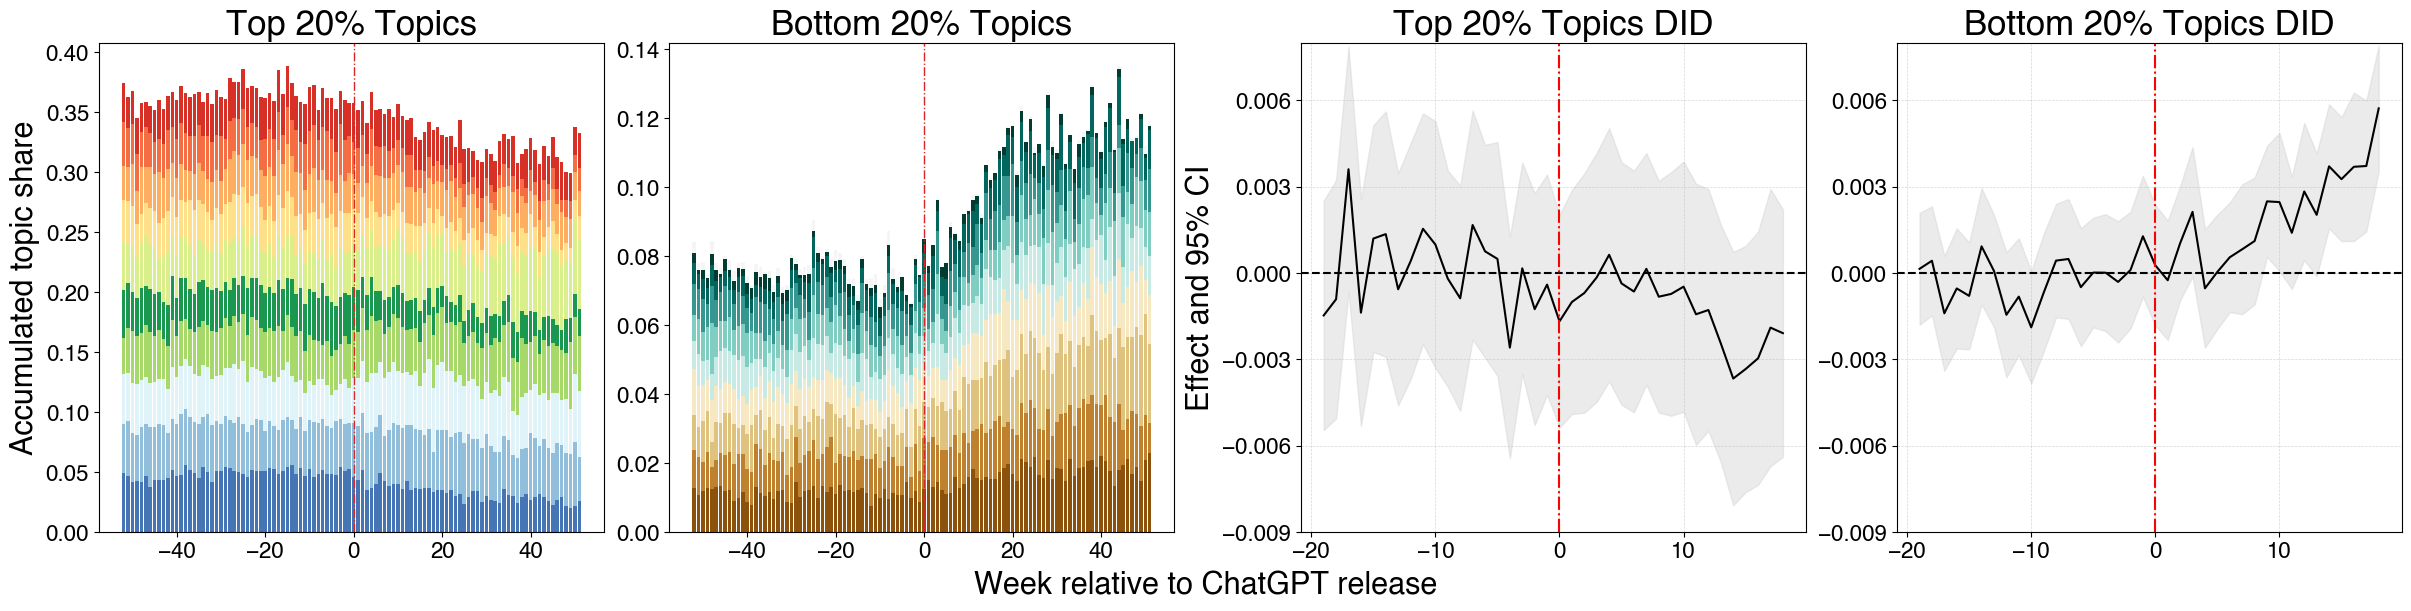

In [41]:

### create a figure with multiple subplots
sharey = True ## 또는 sharey=False
sharex = True ## 또는 sharex=False
# g_num  = len(proportion_dict.items())

fig, axs = plt.subplots(1, 4, figsize = (24, 6), constrained_layout=True)
colors = plt.get_cmap('tab20').colors 


for x, (title, proportion) in enumerate(proportion_dict.items()):
    rel_week = sorted(proportion['rel_week'].unique())  # 주차 순서 보장
    topic_list = list(proportion['Topic'].unique())
    order_list = list_10[title]
    colors = color_list[x]

    # 전체 주차 길이에 맞춰 bottom 초기화
    bottom = np.zeros(len(rel_week))

    for idx, topic in enumerate(order_list):
        # topic별 데이터
        t_p = proportion[proportion['Topic'] == topic]

        # topic별 주차별 비율을 rel_week 길이에 맞춰 채우기
        count_full = np.zeros(len(rel_week))
        for i, rw in enumerate(t_p['rel_week']):
            if rw in rel_week:
                rw_idx = rel_week.index(rw)
                count_full[rw_idx] = t_p.loc[t_p['rel_week'] == rw, 'pct'].values[0]

        # bar plot
        axs[x].bar(rel_week, count_full, bottom=bottom, label=topic, color=colors[idx])
        bottom += count_full  # 누적

    # 보조선 및 제목/레이블 등
    axs[x].axvline(x=0, color='tab:red', linestyle='-.', linewidth=1)
    axs[x].set_title(f'{title}', fontsize=25)
    axs[x].tick_params(axis='x', labelsize=16)
    axs[x].tick_params(axis='y', labelsize=16)


# 신뢰구간 영역
for idx, measure in enumerate(event_effects_dict):
    idx+=2

    axs[idx].fill_between(event_effects_dict[measure]['period'], event_effects_dict[measure]['ll_95'], event_effects_dict[measure]['ul_95'], color='#CFCFCF', alpha=0.4)
    axs[idx].plot(event_effects_dict[measure]['period'], event_effects_dict[measure]['Estimate'], color='black', label='DID Estimate')

    # 기준선
    axs[idx].axhline(0, linestyle='--', color='black')
    axs[idx].axvline(0, linestyle='dashdot', color='red', label='ChatGPT Release')

    # 축 라벨과 제목
    axs[idx].set_title(f"{measure}", fontsize=25)
    axs[idx].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

    axs[idx].set_ylim(-0.009, 0.008)
    axs[idx].set_yticks(np.arange(-0.009, 0.008, 0.003))
    
    axs[idx].tick_params(axis='x', labelsize=16)
    axs[idx].tick_params(axis='y', labelsize=16)


axs[0].set_ylabel("Accumulated topic share", fontsize = 22)
axs[2].set_ylabel(f"Effect and 95% CI", fontsize = 22)

fig.supxlabel("Week relative to ChatGPT release", fontsize=22) 

plt.savefig(f"{output_dir}C_Result_Fig2_2.png", dpi=300, bbox_inches='tight')
plt.show();